# 작동 테스트

In [1]:
import argparse
import time
import torch
import torch.nn.parallel
from contextlib import suppress

from effdet import create_model, create_evaluator, create_dataset, create_loader
from effdet.data import resolve_input_config
from timm.utils import AverageMeter, setup_default_logging
from timm.models.layers import set_layer_config

from matplotlib import pyplot as plt # for visualization
import matplotlib.patches as patches
import numpy as np
import warnings
from PIL import Image
from torchvision.ops.boxes import batched_nms


warnings.filterwarnings(action='ignore')

has_apex = False
try:
    from apex import amp
    has_apex = True
except ImportError:
    pass

has_native_amp = False
try:
    if getattr(torch.cuda.amp, 'autocast') is not None:
        has_native_amp = True
except AttributeError:
    pass

torch.backends.cudnn.benchmark = True

def add_bool_arg(parser, name, default=False, help=''):  # FIXME move to utils
    dest_name = name.replace('-', '_')
    group = parser.add_mutually_exclusive_group(required=False)
    group.add_argument('--' + name, dest=dest_name, action='store_true', help=help)
    group.add_argument('--no-' + name, dest=dest_name, action='store_false', help=help)
    parser.set_defaults(**{dest_name: default})

In [2]:
parser = argparse.ArgumentParser(description='PyTorch ImageNet Validation')
parser.add_argument('root', metavar='DIR',
                    help='path to dataset root') # 디폴트 데이터셋 파싱
parser.add_argument('--dataset', default='coco', type=str, metavar='DATASET',
                    help='Name of dataset (default: "coco"') 
parser.add_argument('--split', default='val',
                    help='validation split')
parser.add_argument('--model', '-m', metavar='MODEL', default='tf_efficientdet_d1',
                    help='model architecture (default: tf_efficientdet_d1)')
add_bool_arg(parser, 'redundant-bias', default=None,
                    help='override model config for redundant bias layers')
add_bool_arg(parser, 'soft-nms', default=None, help='override model config for soft-nms')
parser.add_argument('--num-classes', type=int, default=None, metavar='N',
                    help='Override num_classes in model config if set. For fine-tuning from pretrained.')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('-b', '--batch-size', default=128, type=int,
                    metavar='N', help='mini-batch size (default: 128)')
parser.add_argument('--img-size', default=None, type=int,
                    metavar='N', help='Input image dimension, uses model default if empty')
parser.add_argument('--mean', type=float, nargs='+', default=None, metavar='MEAN',
                    help='Override mean pixel value of dataset')
parser.add_argument('--std', type=float,  nargs='+', default=None, metavar='STD',
                    help='Override std deviation of of dataset')
parser.add_argument('--interpolation', default='bilinear', type=str, metavar='NAME',
                    help='Image resize interpolation type (overrides model)')
parser.add_argument('--fill-color', default=None, type=str, metavar='NAME',
                    help='Image augmentation fill (background) color ("mean" or int)')
parser.add_argument('--log-freq', default=10, type=int,
                    metavar='N', help='batch logging frequency (default: 10)')
parser.add_argument('--checkpoint', default='', type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')
parser.add_argument('--pretrained', dest='pretrained', action='store_true',
                    help='use pre-trained model')
parser.add_argument('--num-gpu', type=int, default=1,
                    help='Number of GPUS to use')
parser.add_argument('--no-prefetcher', action='store_true', default=False,
                    help='disable fast prefetcher')
parser.add_argument('--pin-mem', action='store_true', default=False,
                    help='Pin CPU memory in DataLoader for more efficient (sometimes) transfer to GPU.')
parser.add_argument('--use-ema', dest='use_ema', action='store_true',
                    help='use ema version of weights if present')
parser.add_argument('--amp', action='store_true', default=False,
                    help='Use AMP mixed precision. Defaults to Apex, fallback to native Torch AMP.')
parser.add_argument('--apex-amp', action='store_true', default=False,
                    help='Use NVIDIA Apex AMP mixed precision')
parser.add_argument('--native-amp', action='store_true', default=False,
                    help='Use Native Torch AMP mixed precision')
parser.add_argument('--torchscript', dest='torchscript', action='store_true',
                    help='convert model torchscript for inference')
parser.add_argument('--results', default='', type=str, metavar='FILENAME',
                    help='JSON filename for evaluation results')

_StoreAction(option_strings=['--results'], dest='results', nargs=None, const=None, default='', type=<class 'str'>, choices=None, help='JSON filename for evaluation results', metavar='FILENAME')

In [3]:
def visualization(output,file_number:int, gt:bool = False):
  # ############################
  # visualization aggregation
  # ############################
  '''
  file_number : must be cpu integer
  '''
  colors = ['red','blue','green','yellow','purple']
  fig, ax = plt.subplots()
  if gt == True:
    img_scale = output['img_scale']
    output = output['bbox'][0]
    output *= img_scale
    for bi in range(len(output)):
      box = output[bi]
      b = np.array(box.cpu())
      ax.add_patch(
        patches.Rectangle(
          # 좌표변경 yxyx -> xywh
          (b[1],b[0]),b[3]-b[1] ,b[2]-b[0] , edgecolor = 'red', fill=False)
      )
  else:
    for bi in range(len(output)): # num of box
      box = output[bi]
      b = np.array(box.cpu())
      color_index = int(b[6])
      if color_index ==-1: # integ만 확인
        linewidth=2
      else:
        linewidth=1
      ax.add_patch(
        patches.Rectangle(
          # 좌표변경 xyxy -> xywh
          (b[0],b[1]),b[2]-b[0] ,b[3]-b[1] , edgecolor = colors[color_index], fill=False,linewidth = linewidth)
      
      )
      '''
      centerx = b[0]+ (b[2]-b[0])/2 
      centery = b[1]+ (b[3]-b[1])/2
      ax.text(centerx,centery,b[5])
      '''
  file_number = str(file_number)
  file_name = '0'*(12-len(file_number))+file_number
  img = Image.open('data/val2017/'+file_name+'.jpg')
  ax.imshow(img)   

In [4]:
def aggregation(width,height,num_gpu,output):
  # #########################################
  # aggregation
  # #########################################
  sub_width = int(4*width/(3*int(num_gpu/2)+1)) # 분할된 이미지 크기
  sub_height = int(4*height/(3*int(num_gpu/2)+1))

  ext_width = width-sub_width
  ext_height = height-sub_height

  full_output=output[0] # 3개씩만 처리해보기

  for n in range(1,num_gpu):
    if n==1: #4등분 기준으로 처리
      for o in range(len(output[n])):
        output[n][o][0] += ext_width
        output[n][o][2] += ext_width
    elif n==2:
      for o in range(len(output[n])):
        output[n][o][1] += ext_height
        output[n][o][3] += ext_height
    else:
      for o in range(len(output[n])):
        output[n][o][0] += ext_width
        output[n][o][2] += ext_width
        output[n][o][1] += ext_height
        output[n][o][3] += ext_height

    full_output= torch.cat((full_output,output[n]),dim=0)
  # full_output [160,6]
  # partition index 추가
  gpu_index = torch.zeros([len(full_output),1],device='cuda:0')
  for i in range(num_gpu):
    temp = int(len(full_output)/num_gpu)
    gpu_index[i*temp : (i+1)*temp] = i
  full_output = torch.cat([full_output,gpu_index],dim=1)
  return full_output

In [5]:
def nms(full_output,max_det_per_image=100):
  boxes, sc = torch.split(full_output,4,dim=1)
  scores,classes,gpu_index = torch.split(sc, 1, dim=1)
  scores = scores.squeeze(dim=1)
  classes = classes.squeeze(dim=1)
  gpu_index = gpu_index.squeeze(dim=1)

  top_detection_idx = batched_nms(boxes, scores, classes, iou_threshold=0.5)
  top_detection_idx = top_detection_idx[:max_det_per_image]
  boxes = boxes[top_detection_idx]
  scores = scores[top_detection_idx,None]
  classes = classes[top_detection_idx,None]
  gpu_index = gpu_index[top_detection_idx,None]
  detections = torch.cat([boxes,scores,classes.float(),gpu_index],dim=1)
  num_det = len(top_detection_idx)
  if num_det < max_det_per_image:
        detections = torch.cat([
            detections,
            torch.zeros((max_det_per_image - num_det, 7), device=detections.device, dtype=detections.dtype)
        ], dim=0)
  return detections



In [6]:
def overlap_nms(full_output,iou_threshold = 0.25, mzx_det_per_image=100):
  boxes, sc = torch.split(full_output,4,dim=1)
  scores,classes,gpu_index = torch.split(sc, 1, dim=1)
  scores = scores.squeeze(dim=1)
  classes = classes.squeeze(dim=1)
  gpu_index = gpu_index.squeeze(dim=1)

  def _upcast(t) :
    # Protects from numerical overflows in multiplications by upcasting to the equivalent higher type
    if t.is_floating_point():
        return t if t.dtype in (torch.float32, torch.float64) else t.float()
    else:
        return t if t.dtype in (torch.int32, torch.int64) else t.int()
  
  def box_area(boxes):
    """
    Computes the area of a set of bounding boxes, which are specified by their
    (x1, y1, x2, y2) coordinates.

    Args:
        boxes (Tensor[N, 4]): boxes for which the area will be computed. They
            are expected to be in (x1, y1, x2, y2) format with
            ``0 <= x1 < x2`` and ``0 <= y1 < y2``.

    Returns:
        Tensor[N]: the area for each box
    """
    boxes = _upcast(boxes)
    return (boxes[2] - boxes[ 0]) * (boxes[3] - boxes[1])
  
  def box_iou(boxes1, boxes2):
    """
    boxes1,boxes2  : tensor ( [N,4] )
    """
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)

    lt = torch.max(boxes1[None, :2], boxes2[:2])  # [N,M,2]
    rb = torch.min(boxes1[None, 2:], boxes2[2:])  # [N,M,2]
    
    wh = _upcast(rb - lt).clamp(min=0)  # [N,M,2]
    inter = wh[ :, 0] * wh[ :, 1]  # [N,M]

    #union = area1[:, None] + area2 - inter

    #iou = inter/union
    #return iou
    return inter
  def make_new_box(boxes,chosen_boxes):

    b0 = min(boxes[chosen_boxes][:,0])
    b1 = min(boxes[chosen_boxes][:,1])
    b2 = max(boxes[chosen_boxes][:,2])
    b3 = max(boxes[chosen_boxes][:,3])

    return torch.tensor([b0, b1, b2, b3],device='cuda:0')
  
  def overlap(boxes,scores,classes, gpu_index):
    slack = 10
    st_flag = 0
    while len(boxes):
      
      chosen_boxes = [] # 선택박스 그룹
      chosen_boxes.append(0) # 첫번째 box 입력, index로 관리
      
      # debug code

      for box_index in range(len(boxes)):
        # 같은 파티션이 아니고 유사한 위치에 넓이 또는 높이가 유사한 경우 (범위 픽셀), overlap 조건 필요
        for chosen_index in chosen_boxes:
          flag = True
          if box_iou(boxes[box_index],boxes[chosen_index]) == 0: 
            flag = False # overlap 존재안하는경우
            continue
          if gpu_index[box_index] == gpu_index[0]:
            flag = False # 같은 파티션인경우
            continue
          if ((abs(boxes[box_index][0]-boxes[chosen_index][0]) <slack and abs(boxes[box_index][2]-boxes[chosen_index][2]) <slack)\
            or (abs(boxes[box_index][1]-boxes[chosen_index][1]) <slack and abs(boxes[box_index][3]-boxes[chosen_index][3]) <slack))\
              ==False:
            flag = False # 유사한 위치에 넓이 또는 높이가 유사하지 않은 경우
            continue
          if scores[box_index]-scores[chosen_index]>0.3:
            break # 결합할 box의 class score가 0.3 이상 차이날 경우, 이 경우는 아예 제외
          if flag == True:
            chosen_boxes.append(box_index)
            break
      
      indexes = np.array([i for i in range(len(boxes))])
      indexes = np.delete(indexes,chosen_boxes)

      avg_scores = scores[chosen_boxes].mean() # score는 평균내기
      avg_scores = torch.tensor([[avg_scores]],device='cuda:0')
      if len(chosen_boxes)>1:
        integrated_num_gpu = torch.tensor([[-1]],device='cuda:0')
      else:
        integrated_num_gpu = torch.tensor([[gpu_index[chosen_boxes[0]]]],device='cuda:0')

      integrated_classes = torch.tensor([[classes[:1]]],device='cuda:0')

      
      if st_flag ==0:
        new_boxes = make_new_box(boxes,chosen_boxes)
        new_boxes = new_boxes.unsqueeze(dim=0)
        new_boxes = torch.cat([new_boxes, avg_scores, integrated_classes, integrated_num_gpu],dim=1)
      else: 
        new_box = make_new_box(boxes,chosen_boxes)
        new_box = new_box.unsqueeze(dim=0)
        new_box = torch.cat([new_box, avg_scores, integrated_classes, integrated_num_gpu],dim=1)
        new_boxes = torch.cat([new_boxes,new_box],dim=0)
      
      boxes = boxes[indexes]
      scores = scores[indexes]
      classes = classes[indexes]
      gpu_index = gpu_index[indexes]

      st_flag =1
    return new_boxes

  for index, class_id in enumerate(torch.unique(classes)):
    cur_indices = torch.where(classes==class_id)[0] #특정 클래스에 해당하는 box들
    if index ==0:
      new_boxes = overlap(boxes[cur_indices], scores[cur_indices],classes[cur_indices], gpu_index[cur_indices])
    else:
      new_boxes = torch.cat([new_boxes,overlap(boxes[cur_indices], scores[cur_indices],classes[cur_indices],gpu_index[cur_indices])],dim=0)
  return new_boxes

In [7]:
def validate(args):
    setup_default_logging()

    if args.amp:
        if has_native_amp:
            args.native_amp = True
        elif has_apex:
            args.apex_amp = True
    assert not args.apex_amp or not args.native_amp, "Only one AMP mode should be set."
    args.pretrained = args.pretrained or not args.checkpoint  # might as well try to validate something
    args.prefetcher = not args.no_prefetcher

    # create model
    with set_layer_config(scriptable=args.torchscript):
        extra_args = {}
        if args.img_size is not None:
            extra_args = dict(image_size=(args.img_size, args.img_size))
        # img size는 512*512보다 작을경우 패딩
        extra_args = dict(max_detection_points = 2000, max_det_per_image = 40) #분할 이미지 크기

        bench = create_model(
            args.model,
            bench_task='predict',
            num_classes=args.num_classes,
            pretrained=args.pretrained,
            redundant_bias=args.redundant_bias,
            soft_nms=args.soft_nms,
            checkpoint_path=args.checkpoint,
            checkpoint_ema=args.use_ema,
            **extra_args,
        )
    model_config = bench.config

    param_count = sum([m.numel() for m in bench.parameters()])
    print('Model %s created, param count: %d' % (args.model, param_count))

    bench = bench.cuda()

    amp_autocast = suppress
    if args.apex_amp:
        bench = amp.initialize(bench, opt_level='O1')
        print('Using NVIDIA APEX AMP. Validating in mixed precision.')
    elif args.native_amp:
        amp_autocast = torch.cuda.amp.autocast
        print('Using native Torch AMP. Validating in mixed precision.')
    else:
        print('AMP not enabled. Validating in float32.')

    #''' custom module test
    if args.num_gpu > 1:
        bench = torch.nn.DataParallel(bench, device_ids=list(range(args.num_gpu)))
    #'''

    #print('@@debug@@: ',args.dataset,args.root,args.split) # 디버그 : split_coco, data/split, val

    datasets=[] # 분산 데이터셋 생성
    for i in range(args.num_gpu):
      datasets.append( create_dataset(args.dataset, args.root+'/split_'+str(i), args.split) ) # 데이터셋 생성
    
    input_config = resolve_input_config(args, model_config)

    loaders =  [] # 분산 로더 생성
    for i in range(args.num_gpu):
      loaders.append( create_loader(
          datasets[i],
          input_size=input_config['input_size'],
          batch_size=args.batch_size,
          use_prefetcher=args.prefetcher,
          interpolation=input_config['interpolation'],
          fill_color=input_config['fill_color'],
          mean=input_config['mean'],
          std=input_config['std'],
          num_workers=args.workers,
          pin_mem=args.pin_mem)
          )
    
    # ground truth 용 데이터셋, 로더
    gt_dataset = create_dataset('coco','data','val')
    gt_loader = create_loader(gt_dataset, 
    input_size=input_config['input_size'],
          batch_size=args.batch_size,
          use_prefetcher=args.prefetcher,
          interpolation=input_config['interpolation'],
          fill_color=input_config['fill_color'],
          mean=input_config['mean'],
          std=input_config['std'],
          num_workers=args.workers,
          pin_mem=args.pin_mem)
    gt_loader = iter(gt_loader)
    

    # loader 출력해서 상태살피기
    # 가장 쉬운 방법은 loader를 4개만들어서 출력**

    evaluator = create_evaluator(args.dataset, datasets[0], pred_yxyx=False) # evaluator.py
    #첫번째만 사용해서 체크
    
    bench.eval()
    batch_time = AverageMeter()
    end = time.time()
    last_idx = len(loaders[0]) - 1

    for i in range(len(loaders)):
      loaders[i] = iter(loaders[i])
    
    with torch.no_grad():
        for i in range(last_idx+1):

            # input 생성
            input, target = next(loaders[0])
            #print(target['img_scale'])
            # image size
            width,height = target['img_size'][0]

            # target도 parallel 가능하게 변경
            for key in target.keys():
              temp = target[key]
              for _ in range(1,args.num_gpu):
                temp = torch.cat((temp,target[key]),dim=0)
              target[key] = temp
            

            #print('input:',input.size())
            for n in range(1,args.num_gpu):
              _input,_target = next(loaders[n])
              input = torch.cat( (input, _input), dim=0)

            
            with amp_autocast():
                output = bench(input , img_info=target) # bench.py DetBenchPredict에서 아웃풋 합치는 것 확인
                #img_info 보낼 경우 scale된 결과 return, eval에서는 이걸 사용해야 할수있음
                #output = bench (input)# visualization에서는 이것

            #print('output:',output.size()) # 4, 40, 6
            
            # aggregation
            full_output = aggregation(width,height,args.num_gpu,output)
            ### visualization
            visualization(full_output,int(target['file_name'][0].cpu()))

            # nms이전에 파티션된 조각에서 일정수준이상 겹치면 하나로 통합 
            # 이전 연구에서 25% 이상 겹치면 둘중 하나 제거했는데, 반영 검토
            # https://openaccess.thecvf.com/content_CVPRW_2019/papers/UAVision/Unel_The_Power_of_Tiling_for_Small_Object_Detection_CVPRW_2019_paper.pdf
            outputs = overlap_nms(full_output)
            # nms 1회 더 실행, full_output [160,6], 현재 nms가 분산 간의 상대순위로 발생하기때문에 이를 해결해야함, 
            outputs = nms(outputs)
            #outputs = nms(full_output)

            ### visualization
            visualization(outputs,int(target['file_name'][0].cpu()))

            #eval 에서는 gt_target으로 비교
            gt_input, gt_target = next(gt_loader)
            outputs = torch.unsqueeze(outputs,dim=0) # batch 고려 차원 추가
            evaluator.add_predictions(outputs, gt_target)

            ### ground truth visualization
            visualization(gt_target,int(target['file_name'][0].cpu()),gt = True)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % args.log_freq == 0 or i == last_idx:
                print(
                    'Test: [{0:>4d}/{1}]  '
                    'Time: {batch_time.val:.3f}s ({batch_time.avg:.3f}s, {rate_avg:>7.2f}/s)  '
                    .format(
                        i, last_idx+1, batch_time=batch_time,
                        rate_avg=input.size(0) / batch_time.avg)
                )
                
            
            # 물체가 큰경우 이미지 크기에 비례에서 nms 실행해야함, 이미지간 겹치는크기가 작기 때문
            if i==9:
              break
            
    mean_ap = 0.
    if datasets[0].parser.has_labels:
        mean_ap = evaluator.evaluate(output_result_file=args.results)
    else:
        evaluator.save(args.results)

    return mean_ap
    
    


Model tf_efficientdet_d0 created, param count: 3880067
AMP not enabled. Validating in float32.
loading annotations into memory...
Done (t=0.47s)
creating index...
index created!
loading annotations into memory...
Done (t=0.69s)
creating index...
index created!
loading annotations into memory...
Done (t=0.60s)
creating index...
index created!
loading annotations into memory...
Done (t=0.67s)
creating index...
index created!
loading annotations into memory...
Done (t=0.76s)
creating index...
index created!
Test: [   0/5000]  Time: 11.392s (11.392s,    0.35/s)  
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.348
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.529
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxD

0.3482558930891601

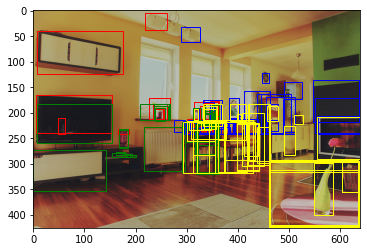

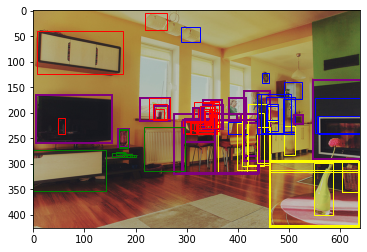

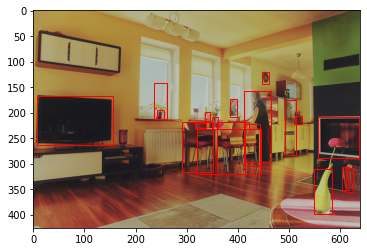

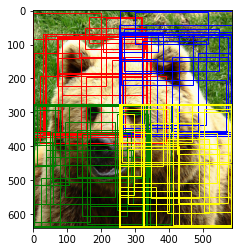

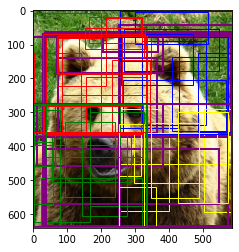

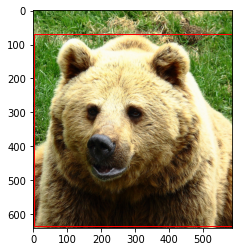

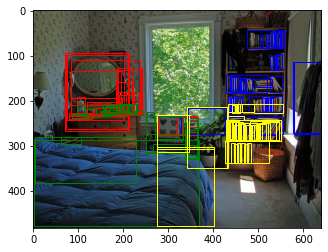

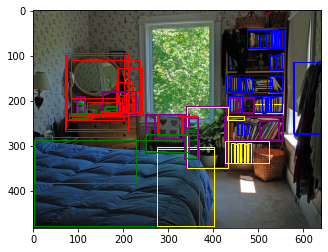

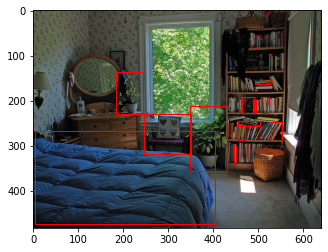

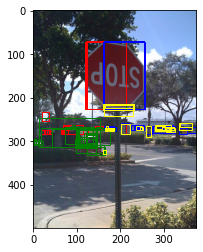

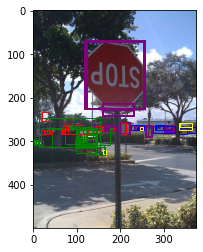

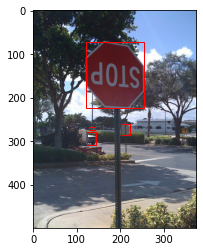

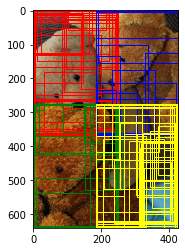

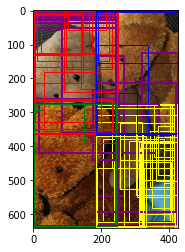

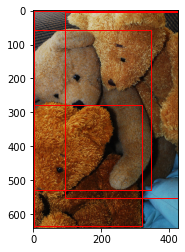

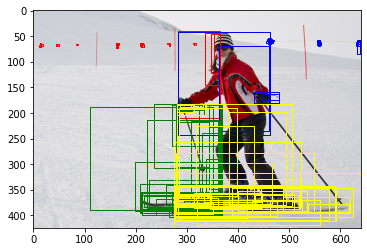

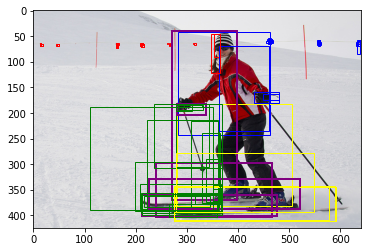

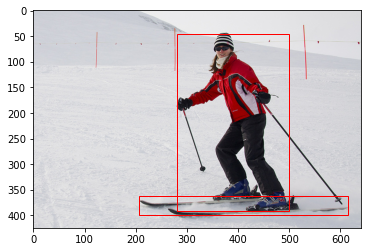

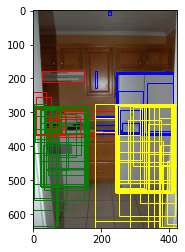

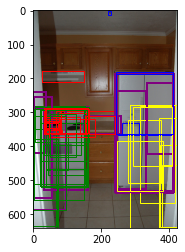

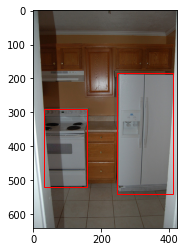

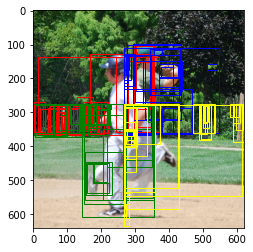

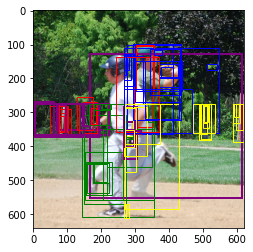

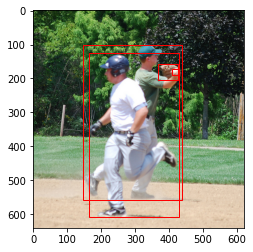

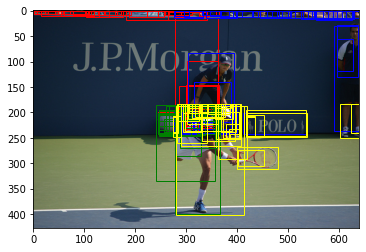

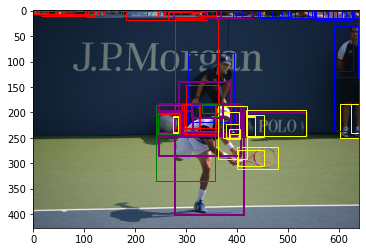

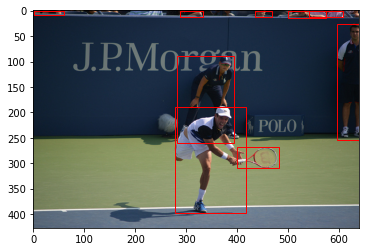

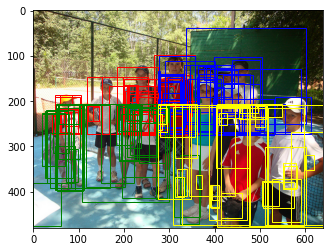

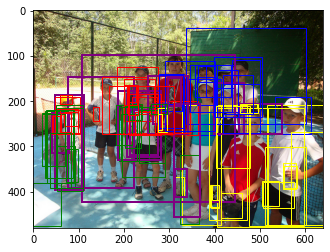

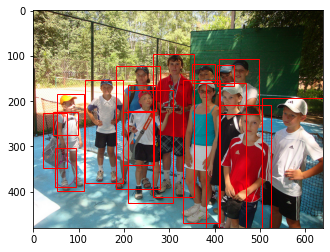

In [8]:
args_str = 'data/split --dataset split_coco --model tf_efficientdet_d0 --num-gpu 4 --batch-size 1'
#args_str = 'data --model tf_efficientdet_d0 --num-gpu 4'
args,_ = parser.parse_known_args(args=args_str.split())
validate(args)

In [179]:
'''

input : [4,3,512,512]

class, box

post process : select top k predictions
input
[1, 810, 64, 64]  [1, 36, 64, 64]            class : 90
out
[1, 5000, 1] [1, 5000, 4]                    indices [1, 5000] classes [1, 5000] 


batch detection
[4, 100, 6]

https://hongl.tistory.com/237

'''



'\n\ninput : [4,3,512,512]\n\nclass, box\n\npost process : select top k predictions\ninput\n[1, 810, 64, 64]  [1, 36, 64, 64]            class : 90\nout\n[1, 5000, 1] [1, 5000, 4]                    indices [1, 5000] classes [1, 5000] \n\n\nbatch detection\n[4, 100, 6]\n\nhttps://hongl.tistory.com/237\n\n'

In [ ]:
'''
  def _upcast(t) :
    # Protects from numerical overflows in multiplications by upcasting to the equivalent higher type
    if t.is_floating_point():
        return t if t.dtype in (torch.float32, torch.float64) else t.float()
    else:
        return t if t.dtype in (torch.int32, torch.int64) else t.int()
  
  def box_area(boxes):
    """
    Computes the area of a set of bounding boxes, which are specified by their
    (x1, y1, x2, y2) coordinates.

    Args:
        boxes (Tensor[N, 4]): boxes for which the area will be computed. They
            are expected to be in (x1, y1, x2, y2) format with
            ``0 <= x1 < x2`` and ``0 <= y1 < y2``.

    Returns:
        Tensor[N]: the area for each box
    """
    boxes = _upcast(boxes)
    return (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
  
  def box_iou(boxes1, boxes2):
    """
    boxes1,boxes2  : tensor ( [N,4] )
    """
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]
    
    wh = _upcast(rb - lt).clamp(min=0)  # [N,M,2]
    inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]

    union = area1[:, None] + area2 - inter

    iou = inter/union
    return iou
  '''